# FPGheArt - Week 2 exercise

### Lorenzo Buriola - 2021860
### Filippo Conforto - 2021856
### Lorenzo Domenichetti - 2011653


(IBM says these colors are good also for color blinds. We hope so!)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD 
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint
import pandas as pd
import time

## Data (strings) and splitting

In [38]:
fname="DATA/sequences16.csv"
sx, sy = np.loadtxt(fname,delimiter=',',
                   usecols= (0,1), unpack=True, dtype = str)

In [39]:
N = len(sy)
print(f"Number of total samples {N}")
Ls = len(sx[0])
print(f"Lenght of a sample {Ls}")

print(f"Sample: {sx[0]}, label: {sy[0]}")

perc_train = 0.8
N_train = int(N*perc_train)
N_test = N -N_train
print(f'\ndata:{N}\ntrain: {N_train}\ntest: {N_test}')

Number of total samples 3000
Lenght of a sample 16
Sample: AAGGTCTGCCGGCCGA, label: 1

data:3000
train: 2400
test: 600


In [40]:
Q = ['A', 'C', 'G', 'T']
Nc=4
onehc = {Q[i]: i for i in range(Nc)}
print(f"One-hot encoding dictionary: {onehc}")

One-hot encoding dictionary: {'A': 0, 'C': 1, 'G': 2, 'T': 3}


## Data conversion: One-Hot Encoding

In [41]:
y = sy.astype(int)

L = Ls*Nc
print(f"Product of lenght ({Ls}) and character possibilities ({Nc}): {L}\n")

x= np.zeros((N,L))

for n in range(N):
    for i in range(Ls):
        x[n][i*4 + onehc[sx[n][i]]] = 1
print(f"Original sequence:\n {sx[0]}\n")
print(f"Encoded sequence:\n {x[0]}")

Product of lenght (16) and character possibilities (4): 64

Original sequence:
 AAGGTCTGCCGGCCGA

Encoded sequence:
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


## Split train/test - validation

In [6]:
(x_train, y_train) = (x[:N_train], y[:N_train])
(x_test, y_test) = (x[N_train:], y[N_train:])
print(f"Ratio between y_train labels sum and train samples: {y_train.sum() / N_train}")
print(f"Ratio between y_test  labels sum and test samples: {y_test.sum() / N_test}")


Ratio between y_train labels sum and train samples: 0.24333333333333335
Ratio between y_test  labels sum and test samples: 0.25833333333333336


## Definition of model in Keras

In [7]:
np.random.seed(123)

model = Sequential()

model.add(Dense(L,input_shape=(L,),activation = "relu"))
model.add(Dense(L/2,activation = "relu"))
model.add(Dense(L/4,activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics= ["accuracy"])

model.save_weights('initial_weights.h5')

## Fit

In [9]:
def plot_res(fit1, label_fit1 = '', fit_compare = None, label_fit_compare = '',  compare = False ):
    '''
    Simple function to plot the history of train and validation accuracy
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))


    # summarize history for loss
    ax1.plot(fit1.history['loss'], label = (label_fit1 + " Train Loss"), color = '#648FFF', lw = 2.5)
    ax1.plot(fit1.history['val_loss'], label = (label_fit1 + " Validation Loss"), color = '#FE6100', lw = 2.5)
    
    if compare: ax1.plot(fit_compare.history['val_loss'], label = label_fit_compare+ ' Validation Loss', color  = '#DC267F', lw = 2.5)


    ax1.legend(loc = 'best')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Model Loss')
    ax1.grid(ls = '--')

    # summarize history for accuracy
    ax2.plot(fit1.history['accuracy'], label = (label_fit1 + ' Train Accuracy'), color =  '#648FFF', lw = 2.5)
    ax2.plot(fit1.history['val_accuracy'], label = (label_fit1 + ' Validation Accuracy'), color = '#FE6100', lw = 2.5)
    if compare: ax2.plot(fit_compare.history['val_accuracy'], label = label_fit_compare+ ' Validation Accuracy', color  = '#DC267F', lw = 2.5)

    ax2.legend(loc = 'best')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Model Accuracy')
    ax2.grid(ls = '--')

    plt.show()
    return

In [10]:
#ModelCheckpoint is used to get the best weights, corresponding to minimum loss
mcp_save = ModelCheckpoint('.mdl_wts_fit.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Loading standard weights
model.load_weights('initial_weights.h5')
#Fit
fit = model.fit(x_train, y_train, epochs=30, batch_size = 50, validation_data = (x_test,y_test), shuffle = True, verbose = 0, callbacks = [mcp_save])

Best Test loss: 0.49
Best Test accuracy: 0.77


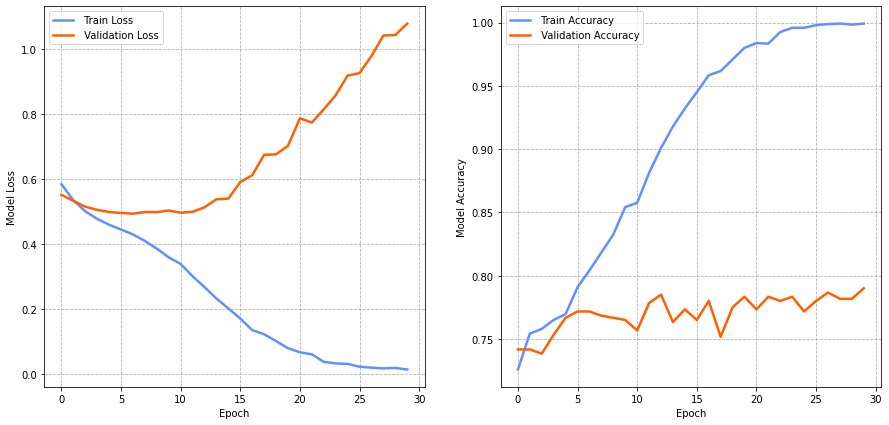

In [11]:
# evaluate model
model.load_weights('.mdl_wts_fit.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)

# print performance
print('Best Test loss: %.2f' %score[0])
print('Best Test accuracy: %.2f' %score[1])

plot_res(fit)

# Data augmentation

In this chapter we try to reshuffle randomly the bases in the sequences keeping the labels constant. 

We are aware of the fact that, in doing so, we introduce some noise as the key for labelling may be in certain cases lost during the reshuffle. Anyhow, given the huge increase in the test samples (16 times), we hope to achieve a better score on the test set.

The discussion on whether one or the other effect is higher is done comparing the results at the end of this section.

### Split train/test - validation

In [12]:
#data augmentation trough shuffling. Every 16 combiations are tried for each sequence
augval = np.asarray([[[v[-i:] + v[:-i],vy] for i in range(16)] for v,vy in zip(sx[:N_train],y[:N_train])]).reshape(38400,2)
augsx = augval[:,0]
augy_train = augval[:,1].astype(int)

In [13]:
#One-Hot encoding for the augmented sequences
augx_train = np.zeros((N_train*16,L))

for n in range(N_train*16):
    for i in range(Ls):
        augx_train[n][i*4 + onehc[augsx[n][i]]] = 1
aug_N_train = N_train*16

## Fit

In [14]:
#Model Fit with Augmented Data
mcp_save = ModelCheckpoint('.mdl_wts_fit_augmented.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model.load_weights('initial_weights.h5')
fit_augmented = model.fit(augx_train, augy_train,
                epochs=30, batch_size = 50, validation_data = (x_test,y_test), shuffle = True, verbose = 0, callbacks = [mcp_save])


Best loss: 0.28
Best accuracy: 0.89


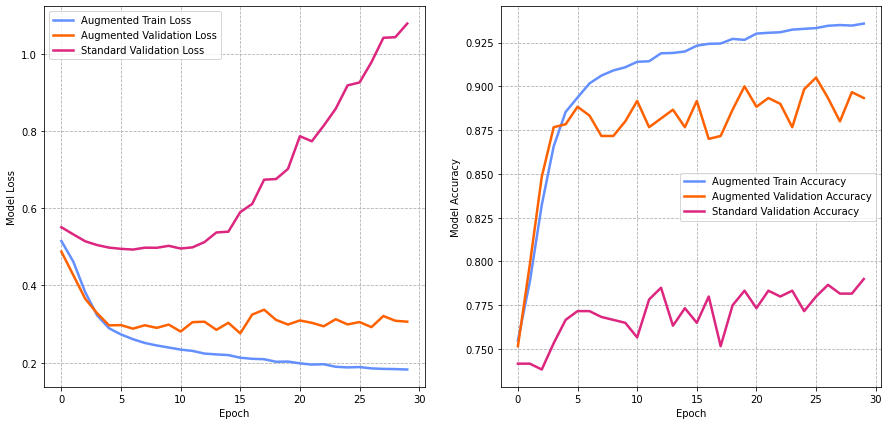

In [16]:
# evaluate model
model.load_weights('.mdl_wts_fit_augmented.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)

# print performance
print()
print('Best loss: %.2f' %score[0])
print('Best accuracy: %.2f' %score[1])

# looking training history

plot_res(fit_augmented, label_fit1 = 'Augmented', label_fit_compare = 'Standard', compare = True, fit_compare = fit)

Even with the randomization introduced, the network provides better results than the previous case. In fact, the validation accuracy is higher than before, while the loss also diminishes. 

Moreover, using more data we prevent the overfitting for a large number of epochs, as we can see in the plot. This ensures the network to continue learning trough different epochs, so increasing the validation accuracy.

# GridSearch for parameter optimization

In the following, we define a GridSearch method for finding the best parameters to fed into the network. Here the gridsearch is performed for the __optimizer__, the __activation function__ and the __dropout rate__ for the last layer, see the appendix for a discussion on the layer structure. 
A cell is entirely commented, as it runs about 500 minimizations (about 30min CPU/GPU time).
Results are provided as an imported csv file. 

In [17]:
def create_DNN(activation, dropout_rate, layers):
    model = Sequential()

    model.add(Dense(L,input_shape=(L,),activation = activation))
    for i in range(len(layers)):
        model.add(Dense(layers[i],activation = activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation="sigmoid"))
    return model


In [18]:
def compile_model(optimizer=keras.optimizers.Adam(), activation = "relu", dropout_rate = 0.2, layers = (L/2, L/4)):
    # create the mode
    model=create_DNN(activation, dropout_rate, layers)
    # compile the model
    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


#### WARNING!!!
The cell below starts a quite heavy GridSearch. It takes abous 30min to finish the hole search. 
We report below the (fortunately) saved results we get after running with the shown parameters.

In [18]:
# # call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn = compile_model)

# # list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# define parameter dictionary
param_grid = dict(optimizer=optimizer, activation = activation, dropout_rate=dropout_rate)
# # call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train, epochs=30, batch_size = 50, shuffle = True)


In [19]:
df_GridSearch = pd.read_csv("DATA/GridSearch_results.csv", index_col = False)
df_GridSearch = df_GridSearch.iloc[:,1:]
df_GridSearch.sort_values(by = "rank_test_score", ascending = True)
df_GridSearch

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_dropout_rate,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.744381,0.285944,0.156408,0.024191,softmax,0.0,SGD,"{'activation': 'softmax', 'dropout_rate': 0.0,...",0.768333,0.743333,0.766667,0.748333,0.756667,0.010992,276
1,1.683135,0.014039,0.144131,0.002644,softmax,0.0,RMSprop,"{'activation': 'softmax', 'dropout_rate': 0.0,...",0.768333,0.743333,0.766667,0.748333,0.756667,0.010992,276
2,1.585771,0.185988,0.149712,0.002874,softmax,0.0,Adagrad,"{'activation': 'softmax', 'dropout_rate': 0.0,...",0.768333,0.256667,0.766667,0.748333,0.635000,0.218572,484
3,1.715497,0.206373,0.176459,0.028340,softmax,0.0,Adadelta,"{'activation': 'softmax', 'dropout_rate': 0.0,...",0.768333,0.743333,0.766667,0.748333,0.756667,0.010992,276
4,1.809999,0.253402,0.154890,0.020702,softmax,0.0,Adam,"{'activation': 'softmax', 'dropout_rate': 0.0,...",0.768333,0.743333,0.766667,0.748333,0.756667,0.010992,276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,0.922601,0.006654,0.083078,0.001907,linear,0.9,Adagrad,"{'activation': 'linear', 'dropout_rate': 0.9, ...",0.768333,0.746667,0.768333,0.746667,0.757500,0.010833,266
556,1.012483,0.068138,0.090344,0.008606,linear,0.9,Adadelta,"{'activation': 'linear', 'dropout_rate': 0.9, ...",0.578333,0.568333,0.410000,0.601667,0.539583,0.075786,529
557,1.124401,0.091408,0.143794,0.098108,linear,0.9,Adam,"{'activation': 'linear', 'dropout_rate': 0.9, ...",0.783333,0.753333,0.771667,0.763333,0.767917,0.011016,154
558,0.996102,0.032718,0.093340,0.009601,linear,0.9,Adamax,"{'activation': 'linear', 'dropout_rate': 0.9, ...",0.780000,0.743333,0.765000,0.771667,0.765000,0.013591,206


In [20]:
df_GridSearch[df_GridSearch["rank_test_score"] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_dropout_rate,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
249,1.066452,0.008873,0.083023,0.000802,relu,0.5,Adam,"{'activation': 'relu', 'dropout_rate': 0.5, 'o...",0.805,0.793333,0.801667,0.808333,0.802083,0.005575,1


The best output is given using __Adam__, a __0.5__ dropout rate on the third layer and __"ReLU"__ as activation function

In [19]:
#New model definition
model = Sequential()

model.add(Dense(L,input_shape=(L,),activation = "relu"))
model.add(Dense(L/2,activation = "relu"))
model.add(Dense(L/4,activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics= ["accuracy"])

In [20]:
#Fit with improved model
mcp_save = ModelCheckpoint('.mdl_wts_fit_augmented_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model.load_weights('initial_weights.h5')
fit_augmented_best = model.fit(augx_train, augy_train,
                epochs=30, batch_size = 50, validation_data = (x_test,y_test), shuffle = True, verbose = 0, callbacks = [mcp_save])


Best loss: 0.26
Best accuracy: 0.90


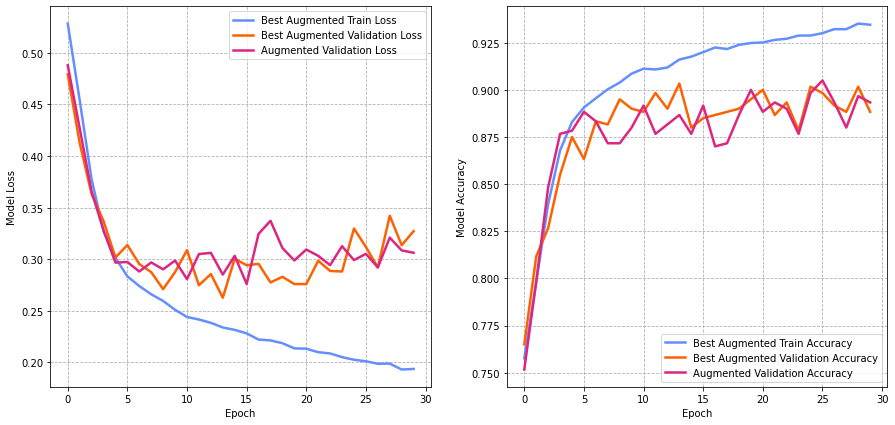

In [21]:
# evaluate model
model.load_weights('.mdl_wts_fit_augmented_best.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)

# print performance
print()
print('Best loss: %.2f' %score[0])
print('Best accuracy: %.2f' %score[1])

# looking training history

plot_res(fit_augmented_best, label_fit1 = 'Best Augmented', label_fit_compare = 'Augmented', compare = True, fit_compare = fit_augmented)

# Centering Data

In these section we investigate what happens rescaling data to a null average. In particular, for OneHotEncoded samples, we replace 1s with 0.75 and 0s with -0.25, so that the total average is zero for every base. 

We exploit as starting data the augmented ones, as the network proves to be more effective when trained on a larger set.

In [22]:
augx_train_c = augx_train.copy()
augx_train_c[augx_train_c==0]=-0.25
augx_train_c[augx_train_c==1]=0.75
x_test_c = x_test.copy()
x_test_c[x_test_c==0]=-0.25
x_test_c[x_test_c==1]=0.75
print(augx_train_c) #augmented and rescaled training set

[[ 0.75 -0.25 -0.25 ... -0.25 -0.25 -0.25]
 [ 0.75 -0.25 -0.25 ... -0.25  0.75 -0.25]
 [-0.25 -0.25  0.75 ...  0.75 -0.25 -0.25]
 ...
 [-0.25 -0.25 -0.25 ... -0.25 -0.25 -0.25]
 [ 0.75 -0.25 -0.25 ... -0.25 -0.25  0.75]
 [-0.25 -0.25 -0.25 ... -0.25 -0.25  0.75]]


In [23]:
#_c stands for "centered"
mcp_save = ModelCheckpoint('.mdl_wts_fit_c.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model.load_weights('initial_weights.h5')
fit_c = model.fit(augx_train_c, augy_train,
                epochs=30, batch_size = 50, validation_data = (x_test_c, y_test), shuffle = True, verbose = 0, callbacks = [mcp_save])

Best Test loss: 0.29
Best Test accuracy: 0.89


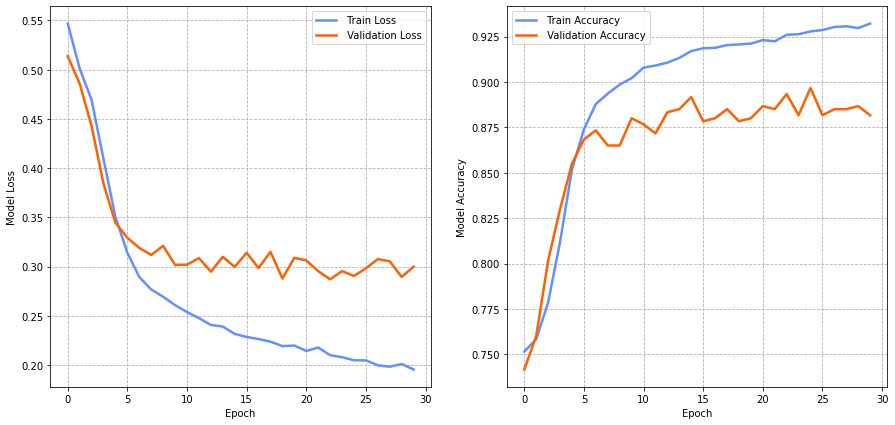

In [24]:
# evaluate model
model.load_weights('.mdl_wts_fit_c.hdf5')
score = model.evaluate(x_test_c, y_test, verbose=0)

# print performance
print('Best Test loss: %.2f' %score[0])
print('Best Test accuracy: %.2f' %score[1])

# look into training history

plot_res(fit_c)

Centering the data does not change the final accuracy significantly.

# Try: Data Uniformity

In the following sections we try to explore whether some bases have more likely a certain position. This would help us avoid using any columns in the following analysis, as they would not provide any additional piece of information. 
(Similar idea to a PCA analysis) 

Anyhow, all data seem to have a uniform pattern troughout all the 16 possible positions.

In [27]:
df = pd.DataFrame([list(s) for s in sx])

In [28]:
df.loc["3000_Acount"] = df[df == 'A'].count(axis = 0)/3000
df.loc["3001_Ccount"] = df[df == 'C'].count(axis = 0)/3000
df.loc["3002_Tcount"] = df[df == 'T'].count(axis = 0)/3000
df.loc["3003_Gcount"] = df[df == 'G'].count(axis = 0)/3000
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,A,A,G,G,T,C,T,G,C,C,G,G,C,C,G,A
1,C,C,T,C,C,C,T,T,A,T,G,G,G,G,G,A
2,T,C,T,C,T,C,G,G,A,A,C,T,G,T,C,A
3,G,T,T,A,A,A,C,G,T,T,A,C,A,T,C,T
4,T,T,A,A,A,T,G,C,T,G,C,T,G,A,T,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,C,G,A,T,T,G,A,A,G,T,G,T,A,C,G,A
3000_Acount,0.263,0.246667,0.255,0.246333,0.247,0.246,0.243,0.256667,0.251,0.249333,0.248667,0.254,0.244,0.258333,0.25,0.250333
3001_Ccount,0.237,0.260667,0.253,0.249,0.242,0.253333,0.257333,0.239667,0.254,0.248,0.253333,0.238,0.265,0.253667,0.254667,0.248333
3002_Tcount,0.246333,0.242,0.236667,0.251667,0.261667,0.25,0.255333,0.252333,0.250333,0.237333,0.255333,0.252,0.252,0.235,0.247667,0.241


# Approach over 15 DNA bases

Let's try to reduce the noise considering the physical properties of bases. 

**Nitrogen triplets** are the building blocks of proteins. A sequence of 16 bases contains only 5 triplets, as a base is not unpaired. 

Augmented and original data will be considered.

We will then reduce the treatment to 15 bases at a time. In the former case, we won't consider the last base in our sequences, in the latter the first one. 

In order to then augment the data, **we only shuffle triplets among themselves**, and not single bases.

In [25]:
x15 = x[:,:-4] #cutting last base from each OneHot sample
(x_train15r, y_train) = (x15[:N_train], y[:N_train])
(x_test15r, y_test) = (x15[N_train:], y[N_train:])

np.random.seed(123)
# given by numb of bases (15) times type of bases (4, for oneHotencoding)
L = 60 

#Keras model definition
model15 = Sequential()

model15.add(Dense(L,input_shape=(L,),activation = "relu"))
model15.add(Dense(L/2,activation = "relu"))
model15.add(Dense(L/4,activation = "relu"))
model15.add(Dropout(0.5))
model15.add(Dense(1,activation="sigmoid"))
model15.save_weights('initial_weights_15.h5')

# model.summary()

model15.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics= ["accuracy"])

mcp_save_15b = ModelCheckpoint('.mdl_wts_fit_15b.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model15.load_weights('initial_weights_15.h5')

fit_15_cutright = model15.fit(x_train15r, y_train,
                epochs=30, batch_size = 50, validation_data = (x_test15r,y_test), shuffle = True, verbose = 0, callbacks=[mcp_save_15b])

Best Test loss: 0.48
Best Test accuracy: 0.75


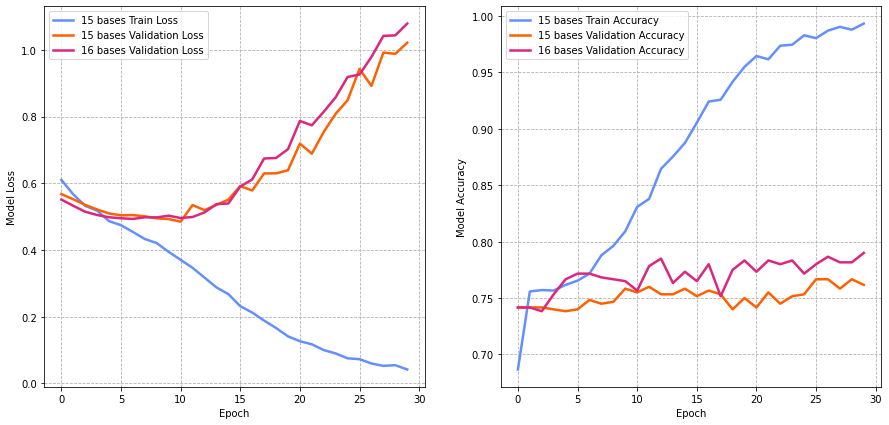

In [26]:
# evaluate model
model15.load_weights('.mdl_wts_fit_15b.hdf5')

score = model15.evaluate(x_test15r, y_test, verbose=0)

# print performance
print('Best Test loss: %.2f' %score[0])
print('Best Test accuracy: %.2f' %score[1])

# look into training history

plot_res(fit_15_cutright, label_fit1 = '15 bases', label_fit_compare = '16 bases', compare = True, fit_compare = fit)

plt.show()

Unexpectedly, we notice that discarding the last base we get very similar results with respect to the first case, in which we did consider all the bases. 

In principle, it means no much information is contained in the very last base. Let's test the network behaviour with augmented data

In [27]:
#Data augmentation
sx15 = [n[:-1] for n in sx]
augval15 = np.asarray([[[v[-i:] + v[:-i],vy] for i in range(0, 15, 3)] for v,vy in zip(sx15[:N_train],y[:N_train])]).reshape(12000,2)
augsx15 = augval15[:,0]
augy_train15 = augval15[:,1].astype(int)


#Showing a sample, with the shuffle of the five triplets contained in the sequence
print(augval15[:5])

[['AAGGTCTGCCGGCCG' '1']
 ['CCGAAGGTCTGCCGG' '1']
 ['CGGCCGAAGGTCTGC' '1']
 ['TGCCGGCCGAAGGTC' '1']
 ['GTCTGCCGGCCGAAG' '1']]


In [28]:
#One-Hot encoding
augx_train15 = np.zeros((N_train*5,L))

for n in range(N_train*5):
    for i in range(15):
        augx_train15[n][i*4 + onehc[augsx15[n][i]]] = 1
aug_N_train = N_train*5

print(f"Augmented train data, shuffled triplets shape: {augx_train15.shape}")

Augmented train data, shuffled triplets shape: (12000, 60)


In [29]:
mcp_save_aug15b = ModelCheckpoint('.mdl_wts_fit_aug15b.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model15.load_weights('initial_weights_15.h5')
fit_aug_cutright15 = model15.fit(augx_train15, augy_train15,
                epochs=30, batch_size = 50, validation_data = (x_test15r,y_test), shuffle = True, verbose = 0, callbacks=[mcp_save_aug15b])

Best Test loss: 0.39
Best Test accuracy: 0.82


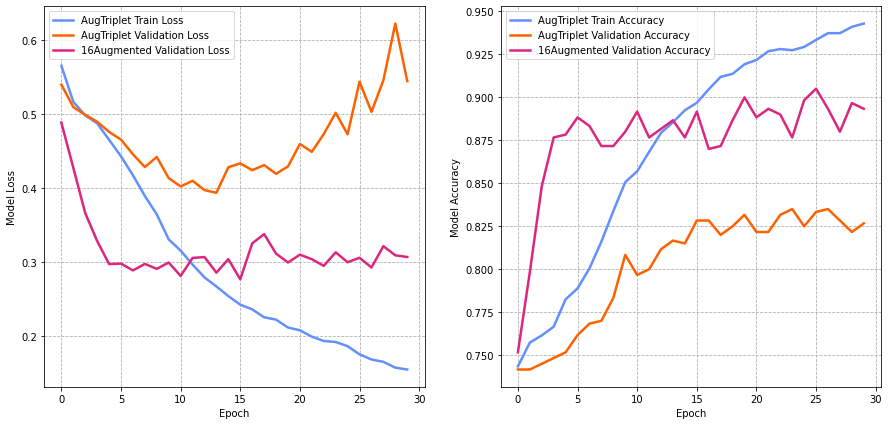

In [30]:
# evaluate model
model15.load_weights('.mdl_wts_fit_aug15b.hdf5')

score = model15.evaluate(x_test15r, y_test, verbose=0)

# print performance
print('Best Test loss: %.2f' %score[0])
print('Best Test accuracy: %.2f' %score[1])

plot_res(fit_aug_cutright15, label_fit1 = 'AugTriplet', label_fit_compare = '16Augmented', compare = True, fit_compare = fit_augmented)

plt.show()

As shown, the *Augmented Random* data still outperform the 15 *Augmented Triplet* ones. 

The network may still find more useful to have more data available. 

## Cutting the first base

Best Test loss: 0.48
Best Test accuracy: 0.76


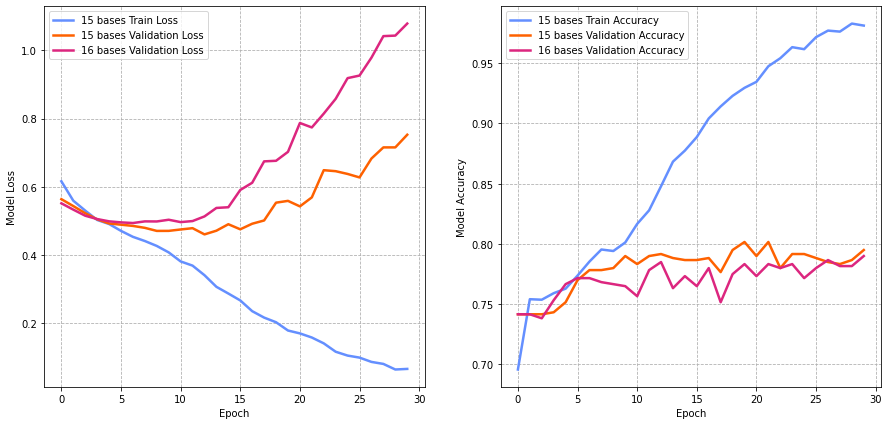

In [31]:
x15 = x[:,4:] #cutting first base from each OneHot sample
(x_train15l, y_train) = (x15[:N_train], y[:N_train])
(x_test15l, y_test) = (x15[N_train:], y[N_train:])

np.random.seed(123)
# given by numb of bases (15) times type of bases (4, for oneHotencoding)
L = 60 

#Keras model definition
model15 = Sequential()

model15.add(Dense(L,input_shape=(L,),activation = "relu"))
model15.add(Dense(L/2,activation = "relu"))
model15.add(Dense(L/4,activation = "relu"))
model15.add(Dropout(0.5))
model15.add(Dense(1,activation="sigmoid"))

# model.summary()

model15.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics= ["accuracy"])

mcp_save_15bl = ModelCheckpoint('.mdl_wts_fit_15bl.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model15.load_weights('initial_weights_15.h5')

fit_15_cutleft = model15.fit(x_train15l, y_train,
                epochs=30, batch_size = 50, validation_data = (x_test15l,y_test), shuffle = True, verbose = 0, callbacks =[mcp_save_15bl])

model15.load_weights('.mdl_wts_fit_15bl.hdf5')

# evaluate model
score = model15.evaluate(x_test15r, y_test, verbose=0)

# print performance
print('Best Test loss: %.2f' %score[0])
print('Best Test accuracy: %.2f' %score[1])

# look into training history

plot_res(fit_15_cutleft, label_fit1 = '15 bases', label_fit_compare = '16 bases', compare = True, fit_compare = fit)

plt.show()

### Data augmentation with cut on first base

Augmented train data, shuffled triplets shape: (12000, 60)
Best Test loss: 0.34
Best Test accuracy: 0.85


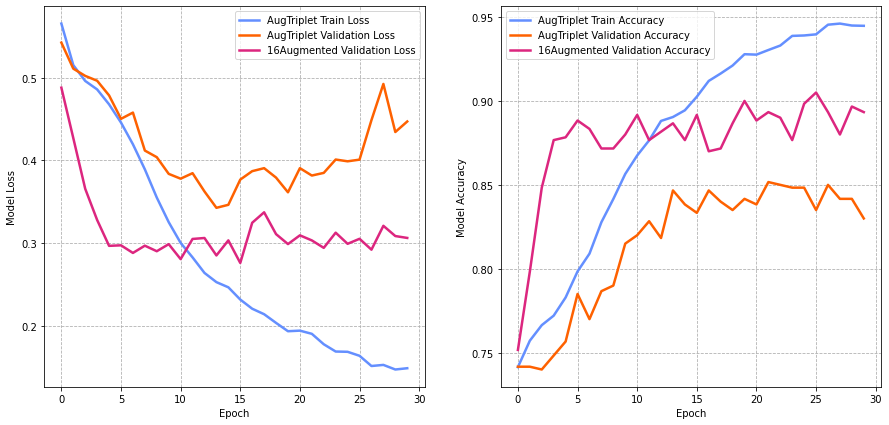

In [32]:
sx15Left = [n[1:] for n in sx]
augval15 = np.asarray([[[v[-i:] + v[:-i],vy] for i in range(0, 15, 3)] for v,vy in zip(sx15Left[:N_train],y[:N_train])]).reshape(12000,2)
augsx15 = augval15[:,0]
augy_train15 = augval15[:,1].astype(int)

augsx15

augx_train15 = np.zeros((N_train*5,L))
for n in range(N_train*5):
    for i in range(15):
        augx_train15[n][i*4 + onehc[augsx15[n][i]]] = 1
aug_N_train = N_train*5

print(f"Augmented train data, shuffled triplets shape: {augx_train15.shape}")
mcp_save_aug15bl = ModelCheckpoint('.mdl_wts_fit_aug15bl.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model15.load_weights('initial_weights_15.h5')

fit_aug_cutright15 = model15.fit(augx_train15, augy_train15,
                epochs=30, batch_size = 50, validation_data = (x_test15r,y_test), shuffle = True, verbose = 0, callbacks = [mcp_save_aug15bl])

model15.load_weights('.mdl_wts_fit_aug15bl.hdf5')

# evaluate model
score = model15.evaluate(x_test15r, y_test, verbose=0)

# print performance
print('Best Test loss: %.2f' %score[0])
print('Best Test accuracy: %.2f' %score[1])

plot_res(fit_aug_cutright15, label_fit1 = 'AugTriplet', label_fit_compare = '16Augmented', compare = True, fit_compare = fit_augmented)

plt.show()

In the Drop-First case, we achieve a similar result w.r.t. what we got in the case of random shuffling, with a third of the training samples. Accuracy in particular is close in both cases.

# Conclusion

The simplest model with the raw data gives a good result (Accuracy = 0.79). As seen, perfomances may improve using  data augmentation. In this specific case the advantages overtake the issues related to incorrect labelling - the accuracy rises up to 0.89.

The best model resulting from a Gridsearch uses *adam* as optimizer, 0.5 as dropout rate and *ReLU* as activation function. 

Data centering also does not give any improvement to the test accuracy. 

As the physical information is contained in triplets one can drop the first or the last base in the sequences, considering only five triplets. Data augmentation can be obtained in this case by shifting triplets. Nevertheless this approach does not provide an improvement compared with the previous augmentation. So, even if this approach may reduce incorrect labelling, a greater number of data yields better results. Moreover, there is no guarantee that the labelling rule depends on the considered triplets alone.

# Appendix

## Layers Dimension Optimization



To get better result we can optimize the layer size, by decreasing the number of total nodes. 

### Definition of model in Keras

In [ ]:
# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn = compile_model)

# define parameter dictionary
layers= [(L/2,), (L/4,), (L/8,), (L/8,L/16), (L/16, L/8),
         (L/32, L/16), (L/16, L/32), (L/32, L/32), (L/16, L/16)
         ,(L/8, L/8), (L/2,L/4), (L/2,L/2), (L/4,L/2), (L/4,L/8), 
         (L/8,L/4), (L/4, L/4), (L/8,L/16,L/16), (L/16, L/8,L/8),
         (L/32, L/16, L/32), (L/16, L/32, L/16)]
batch_size = [20, 50, 100, 150]
param_grid = dict(layers=layers, batch_size = batch_size)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train, y_train, epochs=30, shuffle = True)


In [51]:
print("The best result is associated to {} layers of size {} with a batch size of {}, with a score of {:1.2f}".format(len(grid_result.best_params_["layers"]),grid_result.best_params_["layers"], grid_result.best_params_["batch_size"], grid_result.best_score_))

The best result is associated to 2 layers of size (8.0, 16.0) with a batch size of 20, with a score of 0.81


For this specific case, maybe due to the reduced training set, using larger networks leads to a strong overfit not increasing performances. In particular, the larger the newtork the poorer the results.

In [55]:
pd.DataFrame(grid_result.cv_results_).sort_values(by = "rank_test_score", ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_layers,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
46,1.133532,0.030678,0.129044,0.002996,100,"(4.0, 2.0)","{'batch_size': 100, 'layers': (4.0, 2.0)}",0.768333,0.743333,0.766667,0.748333,0.756667,0.010992,79
67,1.112498,0.046452,0.140803,0.014743,150,"(2.0, 2.0)","{'batch_size': 150, 'layers': (2.0, 2.0)}",0.768333,0.743333,0.766667,0.748333,0.756667,0.010992,79
78,0.660911,0.009873,0.093070,0.004339,150,"(2.0, 4.0, 2.0)","{'batch_size': 150, 'layers': (2.0, 4.0, 2.0)}",0.795000,0.743333,0.766667,0.748333,0.763333,0.020242,78
58,0.801958,0.021402,0.096947,0.006087,100,"(2.0, 4.0, 2.0)","{'batch_size': 100, 'layers': (2.0, 4.0, 2.0)}",0.768333,0.743333,0.795000,0.748333,0.763750,0.020323,76
56,0.784004,0.015112,0.092272,0.003039,100,"(8.0, 4.0, 4.0)","{'batch_size': 100, 'layers': (8.0, 4.0, 4.0)}",0.796667,0.743333,0.766667,0.748333,0.763750,0.020896,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,1.084610,0.083704,0.095505,0.007021,50,"(16.0,)","{'batch_size': 50, 'layers': (16.0,)}",0.801667,0.783333,0.811667,0.800000,0.799167,0.010172,5
1,1.828915,0.069977,0.094942,0.007468,20,"(16.0,)","{'batch_size': 20, 'layers': (16.0,)}",0.813333,0.810000,0.785000,0.796667,0.801250,0.011265,3
0,1.818844,0.009879,0.096701,0.005046,20,"(32.0,)","{'batch_size': 20, 'layers': (32.0,)}",0.810000,0.783333,0.803333,0.808333,0.801250,0.010631,3
42,0.702946,0.004091,0.088793,0.005096,100,"(8.0,)","{'batch_size': 100, 'layers': (8.0,)}",0.811667,0.780000,0.810000,0.805000,0.801667,0.012748,2


## Triplets' shuffling
In order to augment data, in the case of first base drop, one can shuffle the triplets and get 5! sequences from one sequence.

In [32]:
#Train and test division
x15 = x[:,:-4] #cutting last base from each OneHot sample
(x_train15r, y_train) = (x15[:N_train], y[:N_train])
(x_test15r, y_test) = (x15[N_train:], y[N_train:])

In [33]:
augval15 = np.asarray([[[v[-i:] + v[:-i],vy] for i in range(0, 15, 3)] for v,vy in zip(sx15Left[:N_train],y[:N_train])]).reshape(12000,2)
ccc = [ [v[i:i+3] for i in range(0,15,3)] for v in sx15Left[:N_train]]

In [34]:
import itertools

#Produce triplets permutation in the dataset

perms = [  [list(itertools.permutations(trip)), label] for trip, label in zip(ccc,y[:N_train]) ]
labels_vec = []
trdata_vec = []
for p in perms: 
    for trip in p[0]:
        trdata_vec.append(''.join(trip))
        labels_vec.append(p[1])
        


In [35]:
#OneHot Encoding

trdataONEHOT = np.zeros((288000,L))
for n in range(288000):
    for i in range(15):
        trdataONEHOT[n][i*4 + onehc[trdata_vec[n][i]]] = 1




In [36]:
mcp_save_shuffle = ModelCheckpoint('.mdl_wts_fit_shuffle.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model15.load_weights('initial_weights_15.h5')

fit_allPerms = model15.fit(trdataONEHOT, np.array(labels_vec),
                 epochs=30, batch_size = 512, validation_data = (x_test15l,y_test), shuffle = True, callbacks = [mcp_save_shuffle], verbose = 0)


Best Test loss: 0.37
Best Test accuracy: 0.82


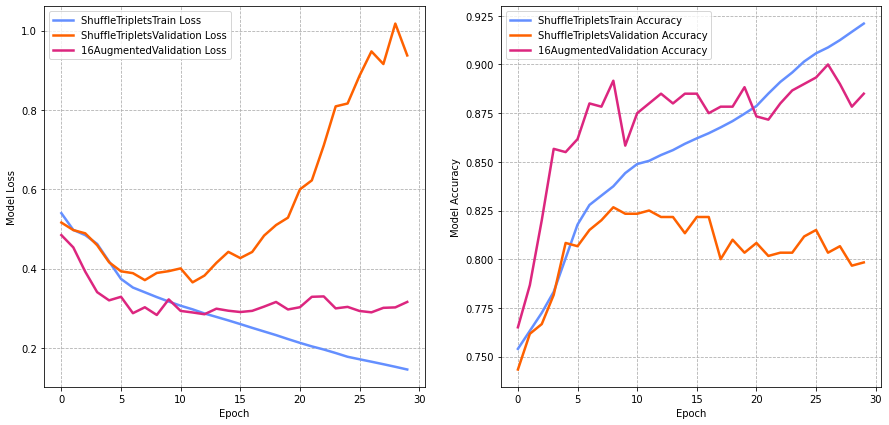

In [37]:
# evaluate model
model15.load_weights('.mdl_wts_fit_shuffle.hdf5')


score = model15.evaluate(x_test15l, y_test, verbose=0)

# print performance
print('Best Test loss: %.2f' %score[0])
print('Best Test accuracy: %.2f' %score[1])

plot_res(fit_allPerms, label_fit1 = 'ShuffleTriplets', label_fit_compare = '16Augmented', fit_compare = fit_augmented, compare = True)

plt.show()

As one can see the results are worse than the 16 bases data augmentation, probably due to the fact that the the rule was broken in the shuffling. Moreover, the network seems to overfit the data in last iterations.